# Imports & Setup

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath("../src"))

from wordcloud import WordCloud
from preprocessor import TextPreprocessor
from sentiment_analyzer import SentimentAnalyzer
from keyword_extractor import KeywordExtractor
from theme_classifier import ThemeClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kumsam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kumsam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kumsam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kumsam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
class ReviewPipeline:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.preprocessor = TextPreprocessor()
        self.sentiment_model = SentimentAnalyzer()
        self.extractor = KeywordExtractor(max_features=100)
        self.classifier = ThemeClassifier()

    def load_data(self):
        self.df = pd.read_csv(self.data_path)

    def preprocess_text(self):
        self.df["cleaned_review"] = self.df["review"].astype(str).apply(self.preprocessor.preprocess)

    def analyze_sentiments(self):
        self.df[["sentiment_label", "sentiment_score"]] = self.df["review"].apply(
            lambda x: pd.Series(self.sentiment_model.analyze(x))
        )

    def extract_keywords(self):
        return self.extractor.extract_keywords(self.df["cleaned_review"])

    def classify_themes(self):
        self.df["themes"] = self.df["cleaned_review"].apply(self.classifier.classify)

    def get_data(self):
        return self.df


#### handled by the pipeline class:

In [3]:
pipeline = ReviewPipeline("../data/bank_reviews_clean.csv")
pipeline.load_data()
pipeline.preprocess_text()
pipeline.analyze_sentiments()
pipeline.classify_themes()
keywords = pipeline.extract_keywords()

df = pipeline.get_data()  # get the processed DataFrame

# -------------------- Sentiment Analysis --------------------

# Sentiment Counts

In [4]:
sentiment_counts = df["sentiment_label"].value_counts()
print("Sentiment\n", sentiment_counts)

Sentiment
 sentiment_label
positive    606
neutral     344
negative    156
Name: count, dtype: int64


# Count Plot

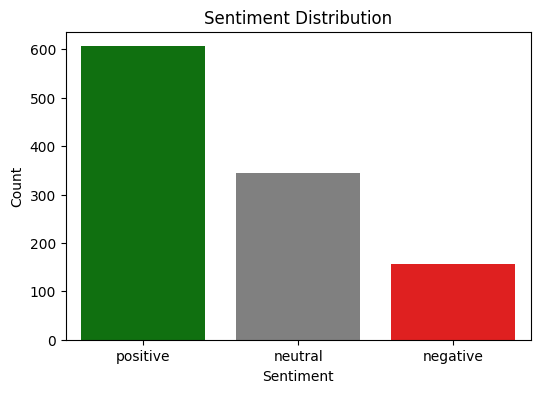

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df,
    x="sentiment_label",
    hue="sentiment_label",
    order=["positive", "neutral", "negative"],
    palette={"positive": "green", "neutral": "gray", "negative": "red"},
    legend=False
)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# WordClouds per Sentiment

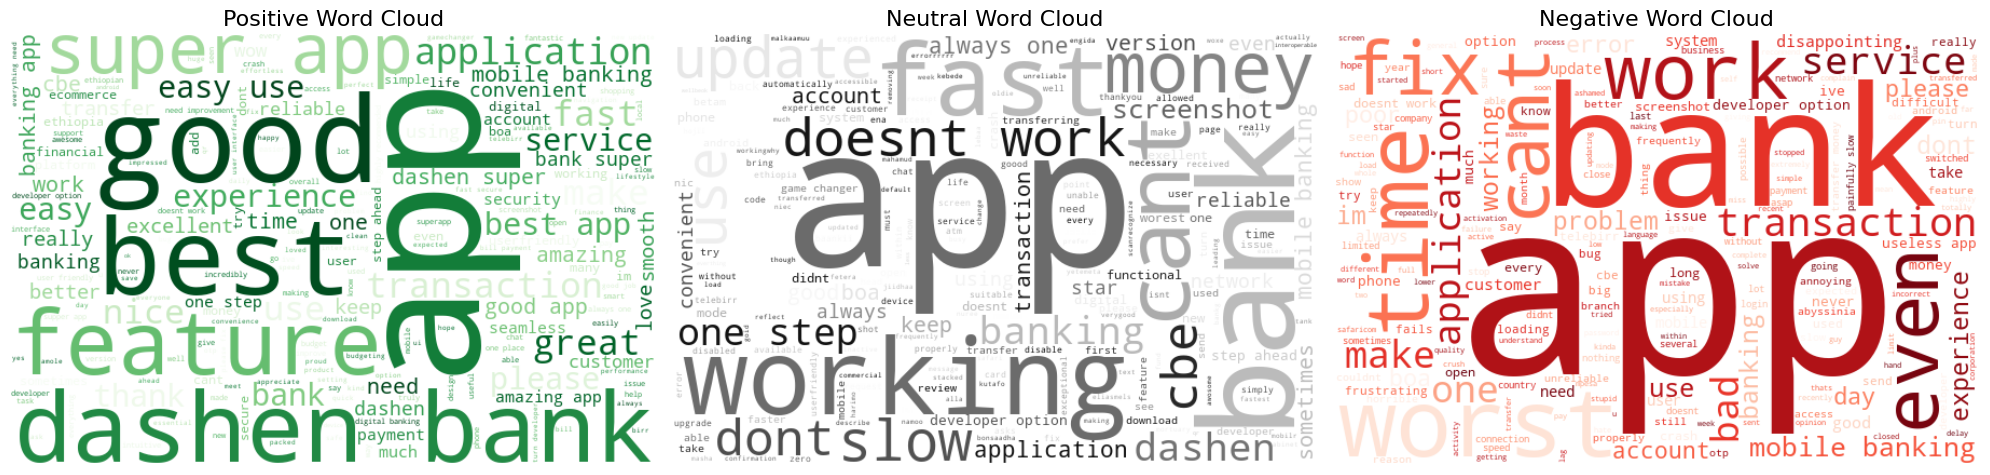

In [6]:
sentiments = ["positive", "neutral", "negative"]
colors = ["Greens", "Greys", "Reds"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, sentiment in enumerate(sentiments):
    text = " ".join(df[df["sentiment_label"] == sentiment]["cleaned_review"].dropna().astype(str))
    wordcloud = WordCloud(width=600, height=400, background_color="white", colormap=colors[idx]).generate(text)
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].axis("off")
    axes[idx].set_title(f"{sentiment.capitalize()} Word Cloud", fontsize=16)

plt.tight_layout()
plt.show()

# Sample Reviews by Sentiment

In [7]:
for sentiment in sentiments:
    print(f"\nSample {sentiment} reviews:")
    sample_reviews = df[df["sentiment_label"] == sentiment]["cleaned_review"].head(5)
    for i, review in enumerate(sample_reviews, start=1):
        print(f"{i}. {review}")


Sample positive reviews:
1. best app finance
2. good
3. nice bank
4. problem solver application go ahead cbe love much
5. good try make facilitate client

Sample neutral reviews:
1. 
2. niec
3. yetemeta
4. engida kebede fetera
5. masha alla

Sample negative reviews:
1. safety
2. like childish app make better worst ever seen
3. recently big problem sending safaricom telebir even cbebirr wallet could anybody responsible fix frustrating day money hasnt returned take account doesnt send mpesa update corrected sent back money still im afraid send
4. lower system everything
5. using app last two year problem stopped working month ago tried transfer fund give error cant transaction inactive account


# -------------- Sentiment score Distribution By User Rating --------------

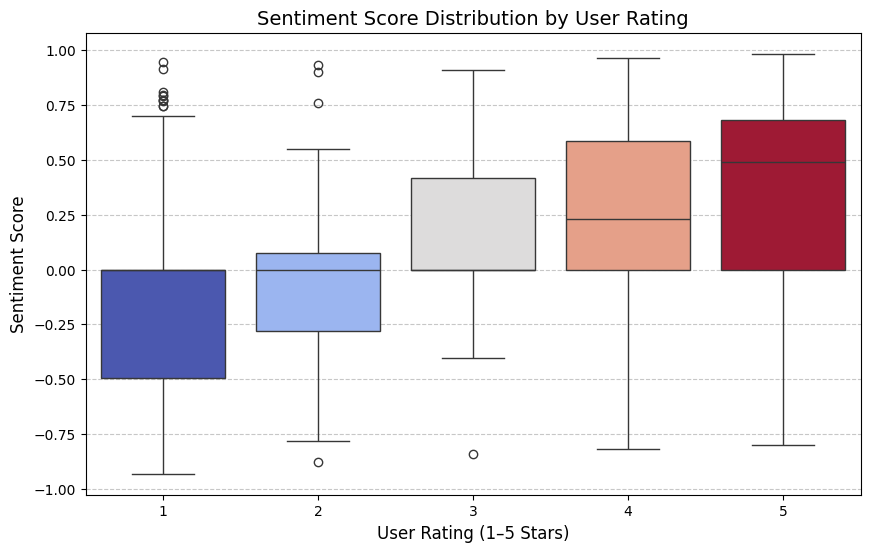

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="rating",
    y="sentiment_score",
    hue="rating",
    palette="coolwarm",
    legend=False
)
plt.title("Sentiment Score Distribution by User Rating", fontsize=14)
plt.xlabel("User Rating (1–5 Stars)", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Keywords from Pipeline

In [9]:
print("Top Keywords:", keywords)

Top Keywords: ['access' 'account' 'ahead' 'also' 'always' 'amazing' 'app' 'app ever'
 'application' 'apps' 'bad' 'bank' 'bank super' 'banking' 'banking app'
 'best' 'best app' 'better' 'boa' 'cant' 'cbe' 'convenient' 'crash'
 'customer' 'dashen' 'dashen bank' 'dashen super' 'day' 'developer'
 'developer option' 'digital' 'doesnt' 'doesnt work' 'dont' 'easy'
 'easy use' 'even' 'ever' 'excellent' 'experience' 'fast' 'feature' 'fix'
 'friendly' 'good' 'good app' 'great' 'im' 'issue' 'ive' 'keep' 'like'
 'love' 'make' 'many' 'mobile' 'mobile banking' 'money' 'much' 'need'
 'new' 'nice' 'one' 'one step' 'option' 'payment' 'phone' 'please'
 'really' 'reliable' 'screenshot' 'seamless' 'secure' 'security' 'service'
 'simple' 'slow' 'smooth' 'sometimes' 'step' 'step ahead' 'super'
 'super app' 'take' 'thank' 'time' 'transaction' 'transfer' 'try' 'update'
 'use' 'used' 'user' 'userfriendly' 'using' 'well' 'work' 'working'
 'worst' 'wow']


# --------------------- Theme Classification -------------------

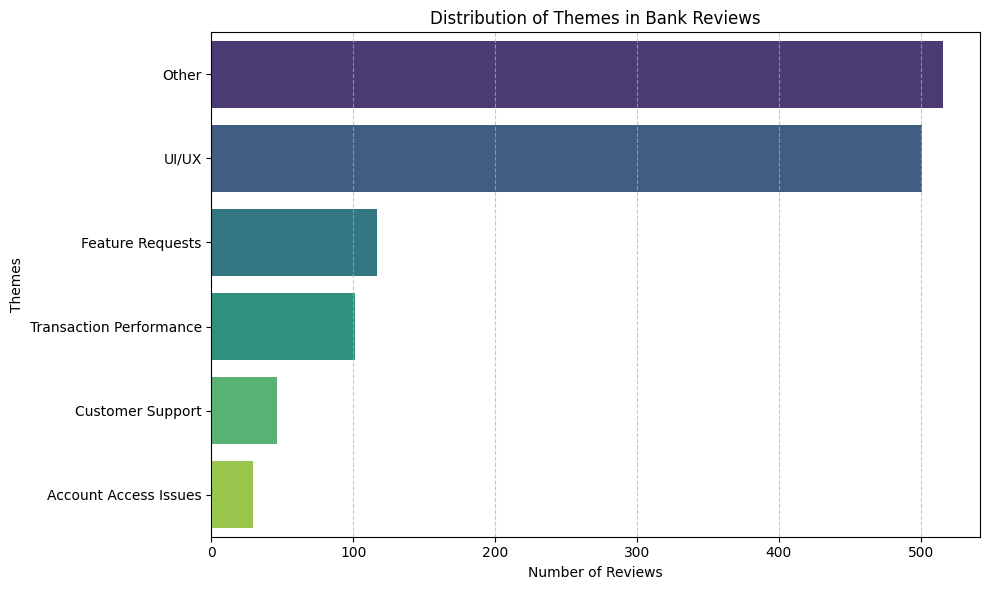

In [10]:
if "themes" in df.columns:
    theme_counts = df["themes"].explode().value_counts().reset_index()
    theme_counts.columns = ["theme", "count"]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=theme_counts,
        x="count",
        y="theme",
        hue="theme",
        palette="viridis",
        dodge=False,
        legend=False
    )
    plt.title("Distribution of Themes in Bank Reviews")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Themes")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'themes' not found in the DataFrame.")